In [2]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-fc_ym_3g
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-fc_ym_3g
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5b72c27ae39f99db75d43f18fd1312e1ea934e60
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

model_final_280758.pkl: 167MB [00:01, 105MB/s]                           


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model Inference Time: 2.1600 seconds
Enter the red value (0-255): 255
Enter the green value (0-255): 0
Enter the blue value (0-255): 0
Enter a key to store the RGB values: Kishre
RGB values for key 'Kishre' saved successfully to rgb_values.json


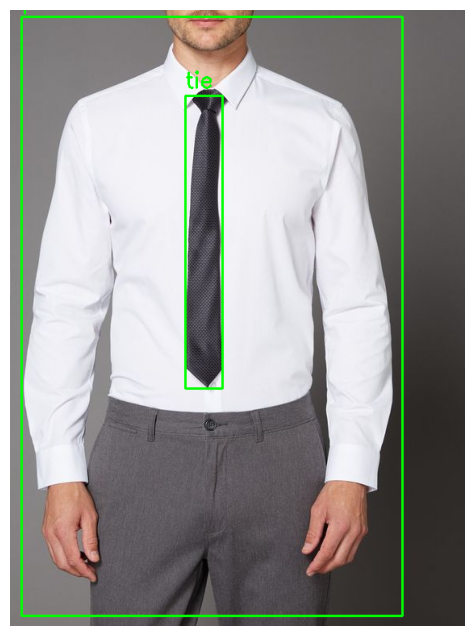

Select the tag to color from the detected objects {'tie', 'person'}: tie


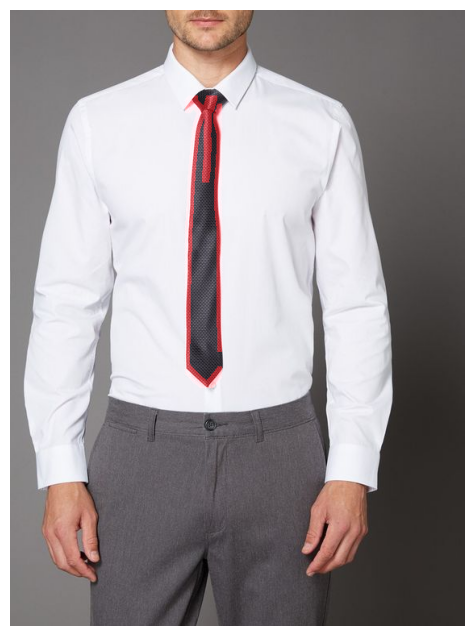

Output image saved as output_image_colored_area_custom.jpg
Processing Time: 0.2752 seconds
Total Execution Time: 27.7844 seconds


In [3]:
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import torch
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
import json

# Timer start
startTime = time.time()

# Load the Faster R-CNN model from Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Ask the user for the input image URL
inputImage_url = input("Enter the image URL: ")
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)

# Read the input image with OpenCV
image = cv2.imread(inputImage_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
inference_start = time.time()
outputs = predictor(image_rgb)
inference_end = time.time()
inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")

# Get the RGB Values to be filled
r_value = int(input("Enter the red value (0-255): "))
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))

# Ask for a key to store the RGB values
rgb_key = input("Enter a key to store the RGB values: ")

# Define a function to save RGB values to a local file
def save_rgb_to_file(key, r, g, b, filename='rgb_values.json'):
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
save_rgb_to_file(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Canny edge detection
def fill_area_with_custom_color(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)  # Adjust thresholds as needed

    # Dilate the edges to close small gaps
    kernel = np.ones((5,5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours from the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the contours
    mask = np.zeros(crop.shape[:2], dtype=np.uint8)

    # Fill the contours with white on the mask
    for contour in contours:
        if cv2.contourArea(contour) > 1000:  # Adjust this threshold as needed
            cv2.drawContours(mask, [contour], 0, 255, -1)

    # Create a custom color overlay based on user input
    custom_overlay = np.zeros_like(crop)
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format

    # Apply the mask to the custom color overlay
    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask)

    # Combine the original image with the custom filled area
    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0)

    return result

# Create a copy of the original image for the final output without bounding boxes
final_image = image.copy()

# Display detected objects and store class names for user input
class_names_detected = []
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE_BW)
output = v.draw_instance_predictions(outputs["instances"].to("cpu"))

for idx, score in enumerate(outputs["instances"].scores):
    if score > 0.5:
        class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[outputs["instances"].pred_classes[idx]]
        class_names_detected.append(class_name)

        # Draw bounding box (green) and put class name on the display image
        x1, y1, x2, y2 = outputs["instances"].pred_boxes.tensor[idx].cpu().numpy().astype(int)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and class tags
image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected
time.sleep(5)

# Now ask the user to select the tag after displaying the image
selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")

# Process detected objects again to fill selected area
processing_start = time.time()
for idx, score in enumerate(outputs["instances"].scores):
    if score > 0.5:
        class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[outputs["instances"].pred_classes[idx]]
        x1, y1, x2, y2 = outputs["instances"].pred_boxes.tensor[idx].cpu().numpy().astype(int)

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Canny detector
            filled_crop = fill_area_with_custom_color(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image_colored_area_custom.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")


model_final_f6e8b1.pkl: 243MB [00:11, 20.8MB/s]                           


Enter the image URL: https://i.pinimg.com/564x/b8/8c/7c/b88c7c29d2da22ef603e409bd5afeeec.jpg
Model Inference Time: 0.2261 seconds
Enter the red value (0-255): 255
Enter the green value (0-255): 0
Enter the blue value (0-255): 0
Enter a key to store the RGB values: Kishore
RGB values for key 'Kishore' saved successfully to rgb_values.json


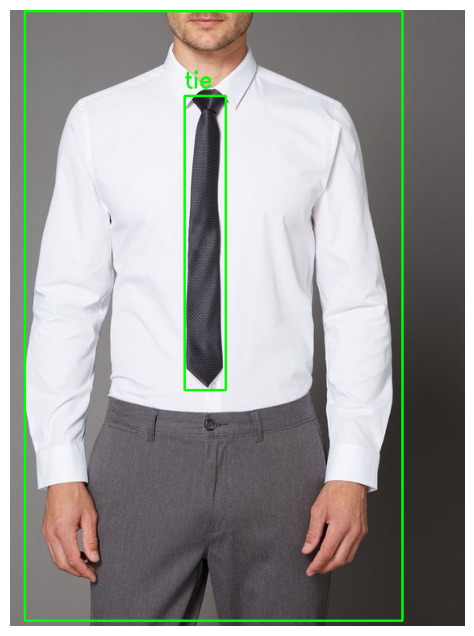

Select the tag to color from the detected objects {'tie', 'person'}: tie


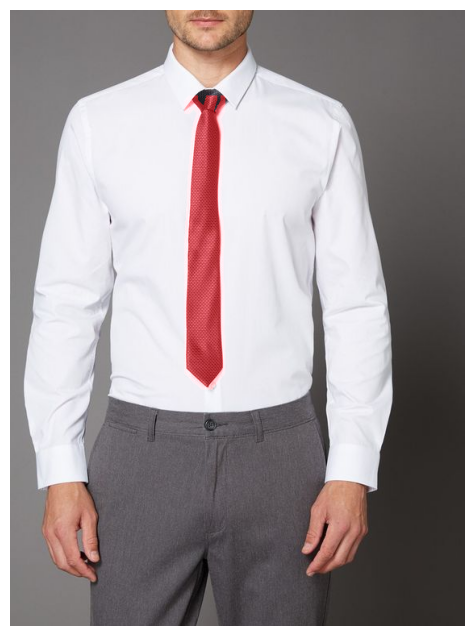

Output image saved as output_image_colored_area_custom.jpg
Processing Time: 0.2097 seconds
Total Execution Time: 35.3884 seconds


In [4]:
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
from urllib.request import urlretrieve
import torch
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
import json

# Timer start
startTime = time.time()

# Load the Faster R-CNN model from Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Ask the user for the input image URL
inputImage_url = input("Enter the image URL: ")
inputImage_path = 'input_image.jpg'
urlretrieve(inputImage_url, inputImage_path)

# Read the input image with OpenCV
image = cv2.imread(inputImage_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
inference_start = time.time()
outputs = predictor(image_rgb)
inference_end = time.time()
inference_duration = inference_end - inference_start
print(f"Model Inference Time: {inference_duration:.4f} seconds")

# Get the RGB Values to be filled
r_value = int(input("Enter the red value (0-255): "))
g_value = int(input("Enter the green value (0-255): "))
b_value = int(input("Enter the blue value (0-255): "))

# Ask for a key to store the RGB values
rgb_key = input("Enter a key to store the RGB values: ")

# Define a function to save RGB values to a local file
def save_rgb_to_file(key, r, g, b, filename='rgb_values.json'):
    rgb_data = {}

    # Try to read the existing data, if the file exists
    try:
        with open(filename, 'r') as file:
            rgb_data = json.load(file)
    except FileNotFoundError:
        pass

    # Store the new RGB values against the key
    rgb_data[key] = {'red': r, 'green': g, 'blue': b}

    # Write the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(rgb_data, file, indent=4)

    print(f"RGB values for key '{key}' saved successfully to {filename}")

# Save the RGB values to a file
save_rgb_to_file(rgb_key, r_value, g_value, b_value)

# Define the function to fill the area with a custom color using Canny edge detection
def fill_area_with_custom_color(crop, b_value, g_value, r_value):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)  # Adjust thresholds as needed

    # Dilate the edges to close small gaps
    kernel = np.ones((5,5), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=2)

    # Find contours from the dilated edges
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the contours
    mask = np.zeros(crop.shape[:2], dtype=np.uint8)

    # Fill the contours with white on the mask
    for contour in contours:
        if cv2.contourArea(contour) > 1000:  # Adjust this threshold as needed
            cv2.drawContours(mask, [contour], 0, 255, -1)

    # Create a custom color overlay based on user input
    custom_overlay = np.zeros_like(crop)
    custom_overlay[:] = (b_value, g_value, r_value)  # BGR color format

    # Apply the mask to the custom color overlay
    custom_filled_area = cv2.bitwise_and(custom_overlay, custom_overlay, mask=mask)

    # Combine the original image with the custom filled area
    result = cv2.addWeighted(crop, 1, custom_filled_area, 0.5, 0)

    return result

# Create a copy of the original image for the final output without bounding boxes
final_image = image.copy()

# Display detected objects and store class names for user input
class_names_detected = []
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE_BW)
output = v.draw_instance_predictions(outputs["instances"].to("cpu"))

for idx, score in enumerate(outputs["instances"].scores):
    if score > 0.5:
        class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[outputs["instances"].pred_classes[idx]]
        class_names_detected.append(class_name)

        # Draw bounding box (green) and put class name on the display image
        x1, y1, x2, y2 = outputs["instances"].pred_boxes.tensor[idx].cpu().numpy().astype(int)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes and class tags
image_rgb_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb_display)
plt.axis('off')
plt.show()

# Add a 5-second delay before asking for the object to be selected
time.sleep(5)

# Now ask the user to select the tag after displaying the image
selected_tag = input(f"Select the tag to color from the detected objects {set(class_names_detected)}: ")

# Process detected objects again to fill selected area
processing_start = time.time()
for idx, score in enumerate(outputs["instances"].scores):
    if score > 0.5:
        class_name = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[outputs["instances"].pred_classes[idx]]
        x1, y1, x2, y2 = outputs["instances"].pred_boxes.tensor[idx].cpu().numpy().astype(int)

        if class_name.lower() == selected_tag.lower():
            # Crop the detected region from the final image (without boxes)
            crop = final_image[y1:y2, x1:x2]

            # Fill the area with custom color using Canny detector
            filled_crop = fill_area_with_custom_color(crop, b_value, g_value, r_value)

            # Replace the cropped region in the final image (without boxes)
            final_image[y1:y2, x1:x2] = filled_crop

# Convert to RGB for displaying with matplotlib
final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# Display the final image with the filled area and no bounding boxes or tags
plt.figure(figsize=(12, 8))
plt.imshow(final_image_rgb)
plt.axis('off')
plt.show()

# Save the output image without green boxes and labels
output_image_path = 'output_image_colored_area_custom.jpg'
cv2.imwrite(output_image_path, final_image)

processing_end = time.time()
processing_duration = processing_end - processing_start
total_duration = time.time() - startTime

# Print performance results
print(f"Output image saved as {output_image_path}")
print(f"Processing Time: {processing_duration:.4f} seconds")
print(f"Total Execution Time: {total_duration:.4f} seconds")
